<div style="background-color: teal; padding: 10px;">
    <h3 style="color: white;">Experiment Two - Win/Loss Prediction</h3>
</div>

#### Goal

Experiment 2:  Build a win/loss prediction model based on data from nflverse

 - The independent values consist of situations such as drive, down, yards to go seconds reaminign in the game, etc. as well as statistics such as yards gained, yards lost, etc.

- The dependent or "Y" features are simply whether the game was won or lost = WIN/LOSS - ties are bundled with wins to keep it a simple binary classification problem

- predict wins and losses for each team in each week of the 2022 season

#### Scope
- This is a 'toy' model.  Although it correctly predicts games in 2022 with just the team stats, it already has the stats data for the game it's predicting.  In real life we will not have those stats until the end of the game.  We could use stats from previous games over the season, but at the beginning of the season we would not have the same quality or amount of stats. Reworking this to be deployable is out of the mandate of this project which is just to see if we can use the data for predictions.


#### Input

- weekly_game_stats.parquet

#### Steps:

- split the data into 2016-2021 train, and 2022 test sets
- build a keras model to predict win/loss
- build and train a keras nn model on 2016-2021 data
- use the model to predict 2022 data
- merge the predictions back into the test set and save the results
- merge the shap scores back into the train set and save the results

#### Output

- team_week_model.keras
- exp2_game_predictions
- exp2_shap_scores



<div style="background-color: teal; padding: 10px;">
    <h3 style="color: white;">imports</h3>
</div>

We'll take care of some housekeeping here - importing libraries, setting up the environment, etc.

In [1]:
import os
import sys

sys.path.append(os.path.abspath("../src"))

In [2]:
import numpy as np
from matplotlib import pyplot as plt

import warnings

warnings.filterwarnings('ignore')


In [3]:
from src import *

<div style="background-color: teal; padding: 10px;">
    <h3 style="color: white;">setup</h3>
</div>

Set any flags and variables we'll need for the rest of the notebook

In [4]:
DEBUG = False
SCHEMA = 'controls'

# plt.style.use('ggplot')
plt.style.use('seaborn-darkgrid')


<div style="background-color: teal; padding: 10px;">
    <h3 style="color: white;">load weekly game stats</h3>
</div>

Load the weekly game stats from the parquet file

In [5]:
file_name = get_config('game_stats')
data_directory = get_config('data_directory')
input_path = os.path.join(data_directory, f"{file_name}.parquet")
assert os.path.exists(input_path)

weekly_stats_df = pd.read_parquet(input_path)
stats_df = weekly_stats_df.copy()

<div style="background-color: teal; padding: 10px;">
    <h3 style="color: white;">prepare data</h3>
</div>

Prepare the data for modeling.  Split the 2016-2021 data into a train set. We are going to strip out all the descriptive labels and columns from the train data, so we want to keep this labeled set that we can merge shap scores back into later.

We'll also split the 2022 data into a test set. Like the train set we are going to strip out all the descriptive labels and columns,and we want to keep this version so we can merge the predictions back into it later.


### <font color="#9370DB">split into train and test sets</font>
Use 2016 through 2011 seasons to predict the 2022 season

In [6]:

from sklearn.preprocessing import MinMaxScaler

def scale_numeric_columns(df, scaler=MinMaxScaler()):
    features = scaler.fit_transform(df.to_numpy())
    X = pd.DataFrame(features, columns=df.columns)
    return X

drop_columns = [ 'season', 'week', 'game_id', 'home_team', 'away_team', 'home_final_score' , 'away_final_score']

scaler = MinMaxScaler()

game_train = stats_df.loc[stats_df['season'] < 2022]
game_test = stats_df.loc[stats_df['season'] == 2022]

X_train = game_train[configs.ml_win_lose_features]
y_train = game_train[['loss_tie_win']]
X_test = game_test[configs.ml_win_lose_features]
y_test = game_test[['loss_tie_win']]

X_train = scale_numeric_columns(X_train, scaler)
X_test = scale_numeric_columns(X_test, scaler)

print(X_train.columns, len(X_train.columns))


Index(['carries_hop', 'carries_aop', 'receiving_tds_hop', 'receiving_tds_aop',
       'passer_rating_hop', 'passer_rating_aop', 'pass_touchdowns_hop',
       'pass_touchdowns_aop', 'special_teams_tds_hop', 'special_teams_tds_aop',
       'rushing_yards_hop', 'rushing_yards_aop', 'rushing_tds_hop',
       'rushing_tds_aop', 'receiving_yards_hop', 'receiving_yards_aop',
       'receiving_air_yards_hop', 'receiving_air_yards_aop',
       'ps_interceptions_hdp', 'ps_interceptions_adp', 'interception_hdp',
       'interception_adp', 'qb_hit_hdp', 'qb_hit_adp', 'sack_hdp', 'sack_adp',
       'tackle_hdp', 'tackle_adp', 'sack_yards_hdp', 'sack_yards_adp',
       'home_team_offense_power', 'home_team_defense_power',
       'away_team_offense_power', 'away_team_defense_power'],
      dtype='object') 34


<div style="background-color: teal; padding: 10px;">
    <h3 style="color: white;">create and execute the team-week win/loss models</h3>
</div>

Create and run the model with a validation split of 25% and 500 epochs - we have early stopping set, so it will not run to 500 epochs unless it needs to.

In [25]:
from src.models.team_week_model import create_team_week_model, train_team_week_model

model = create_team_week_model(
    X_train.shape[1],
    regularization_rate=.001,
    activation_function="relu",
    output_function="sigmoid")

r = train_team_week_model(model=model, X=X_train, y=y_train,
                               epochs_size=500,
                               batch_size=32,
                               verbose=0,
                               learning_rate=.001,
                               validation_split=0.25,
                               # validation_data=(X_test, y_test),
                               loss_function='binary_crossentropy')


2023-07-27 13:10:41.414783: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-27 13:10:41.947428: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


<div style="background-color: teal; padding: 10px;">
    <h3 style="color: white;">review model performnce</h3>
</div>

### <font color="#9370DB">plot loss</font>

The loss is how the model used gradient descent / back propagation to shrink the error between the predicted and actual values.  We want to see the loss go down each epoch as the model learns the data.

The blue line is the training loss and the orange line is the loss on the 25% validation split that we held out from training.  We want to see the validation loss go down each epoch as well.  If the validation loss starts to go up, it means the model is overfitting the data and we should stop training.

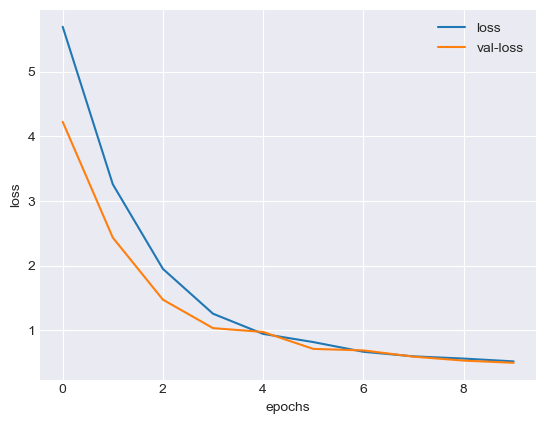

In [26]:

from src.util.utils_eda import plot_loss

plot_loss(r)

### <font color="#9370DB">plot accuracy</font>
Accuracy is the percentage of correct predictions.  We want to see the accuracy go up each epoch as the model learns the data.

Again, the blue line is the training accuracy and the orange line is the accuracy on the 25% validation split that we held out from training.  We want to see the validation accuracy go up each epoch as well.

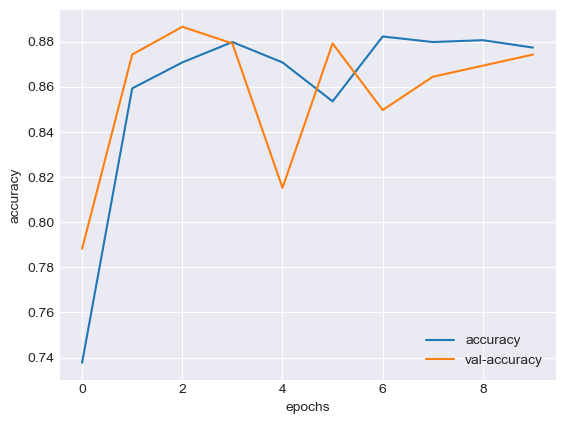

In [27]:
from src.util.utils_eda import plot_accuracy

plot_accuracy(r)

<div style="background-color: teal; padding: 10px;">
    <h3 style="color: white;">explain results</h3>
</div>

first we'll use SHAP to explain how the model weights each feature to make its predictions.  

2023-07-27 13:09:31.077793: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


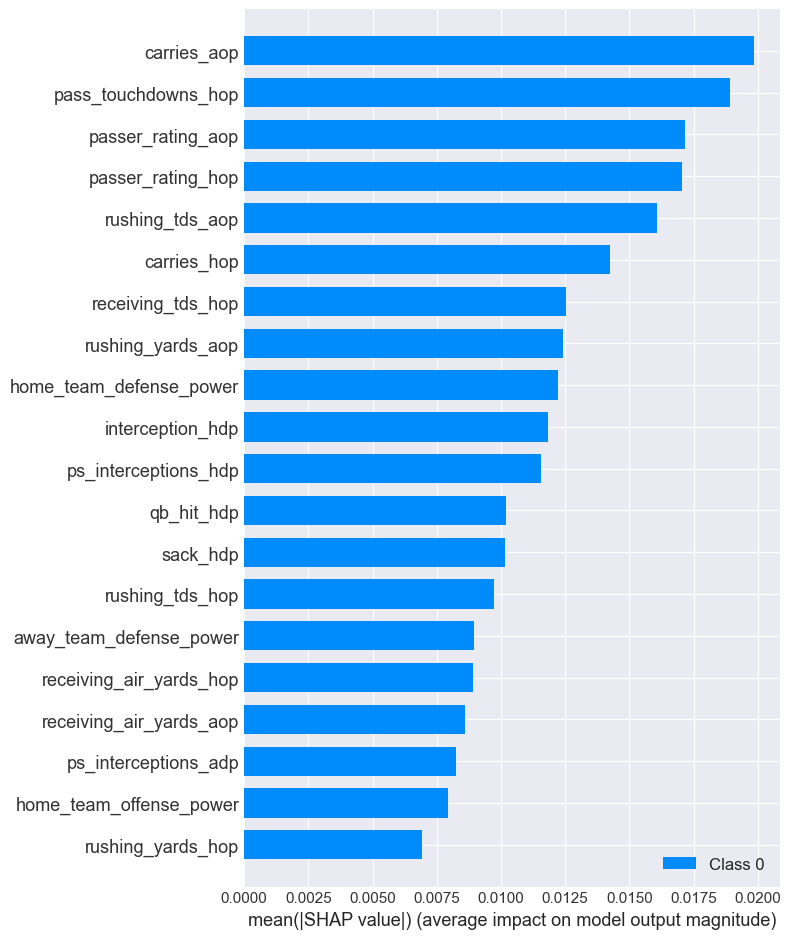

In [10]:
import shap

# Assuming you have a trained Keras model 'model' and a dataset 'X'
explainer = shap.DeepExplainer(model, data=X_train.values)
shap_values = explainer.shap_values(X_train.values)

# save off the explanation so we can review later
game_train_with_shap = pd.concat([game_train['game_id'], pd.DataFrame(shap_values[0], columns=X_train.columns)], axis=1)

# Calculate the mean absolute SHAP values and standard deviations
summary_data = pd.DataFrame({
    'Feature': X_train.columns,
    'Mean': np.abs(shap_values[0]).mean(axis=0)  # Corrected this line to use shap_values[0] directly
})

# Plotting the SHAP values with column names
shap.summary_plot(shap_values, X_train, feature_names=X_train.columns)

<div style="background-color: teal; padding: 10px;">
    <h3 style="color: white;">evaluate performance</h3>
</div>

Now that we've reviewed how the model learned, and what the model thinks is important in the data, we can use the model to predict the 2022 season and see how it performs.

### <font color="#9370DB">perfom the prediction for 2022</font>
- convert the probabilities to binary predictions using a threshold of 0.5
- merge the predictions back into the game_test set


In [11]:

threshold = 0.5
y_pred_probs = model.predict(X_test)
y_pred_binary = (y_pred_probs >= threshold).astype(int)
count = np.sum(y_pred_probs > 0.5)
print('Count of positive predictions: ', count)

game_test['y_pred_binary'] = y_pred_binary

9/9 [==============================] - 0s 4ms/step
Count of positive predictions:  161


2023-07-27 13:09:41.554992: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [12]:
# save off the predictions so we can review them
game_test['y_pred_binary'] = y_pred_binary

### <font color="#9370DB">precision, recall, f1, auc</font>
Get the precision, recall, f1, and auc scores for the predictions.   We want to see the f1 score be as close to 1 as possible.  The scores are pretty consistently in the high or mid 80s, which is acceptable for our needs - so the model is doing a pretty good job.

In [13]:
from src.util.utils_eda import print_f1_scores
from sklearn.metrics import roc_auc_score

print_f1_scores(y_pred_binary, y_test)



Precision: 0.8633540372670807
Recall: 0.8580246913580247
F1-score: 0.8606811145510836


### <font color="#9370DB">ROC /AUC score</font>
The model - represented by the blue line - is doing far better than random chance - which is represented by the dotted line.

AUC:     0.838848411252783


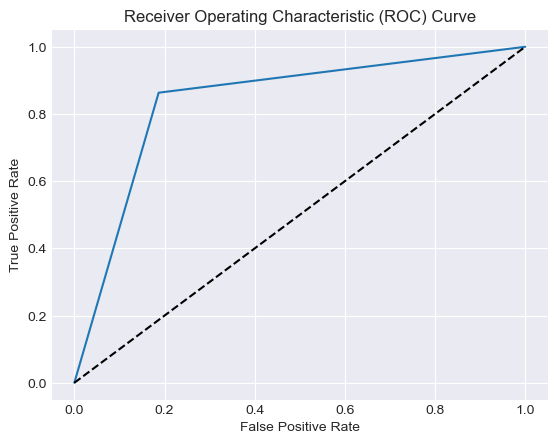

In [14]:
from src.util.util_keras import plot_roc_curve

# Assuming you have y_actual and y_predicted for binary classification
auc = roc_auc_score(y_test, y_pred_binary)
print("AUC:    ", auc)
plot_roc_curve(y_pred_binary, y_test)

### <font color="#9370DB">confusion matrix</font>
We see that the number of correct predictions - upper left and lower right quadrants - is much higher than the number of incorrect predictions - upper right and lower left quadrants.  This is good.

Of the misclassified (errors) the model is misclassifying losses as wins slightly more than wins as losses - 23 losses as wins and 19 wins as losses.

- upper left - true negatives - the model predicted a loss and the actual was a loss
- upper right - false positives - the model predicted a win and the actual was a loss
- lower left - false negatives - the model predicted a loss and the actual was a win
- lower right - true positives - the model predicted a win and the actual was a win

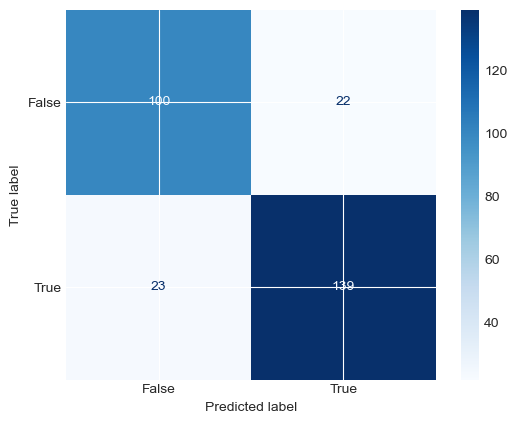

In [15]:
from src.util.utils_eda import plot_confusion_matrix

plot_confusion_matrix(y_pred_binary, y_test)

<div style="background-color: teal; padding: 10px;">
    <h3 style="color: white;">review the predictions</h3>
</div>

We've already merged the predictions into the game_test dataframe.  Now let's create some descriptive fields that make it easier to review the predictions.

In [16]:

# Save test predictions
game_test['point_difference'] = abs(game_test['home_final_score'] - game_test['away_final_score'])
game_test['predicted'] = game_test['y_pred_binary'].apply(lambda x: 'loss' if x == 0 else 'win/tie')
game_test['model_win_loss'] = game_test.apply( lambda row: 'loss' if row['loss_tie_win'] == 0 else 'win/tie' if row['home_final_score'] == row['away_final_score']  else 'win', axis=1)

game_test['actual'] = game_test.apply(lambda row:
                                      'win' if row['home_final_score'] > row['away_final_score']
                                      else 'loss' if row['home_final_score'] < row['away_final_score']
                                      else 'tie', axis=1)

game_test['status'] = game_test.apply(lambda row:
                                      'prediction_error' if row['y_pred_binary'] != row['loss_tie_win']
                                      else 'correct_prediction', axis=1)

game_test['confusion'] = game_test.apply(lambda row:
                                         'misclassified-loss' if row['status'] == 'prediction_error' and row['loss_tie_win'] == 0
                                         else 'misclassified-win' if row['status'] == 'prediction_error' and row['loss_tie_win'] == 1
                                         else 'predicted-loss' if row['status'] == 'correct_prediction' and row['loss_tie_win'] == 0
                                         else 'predicted-win' if row['status'] == 'correct_prediction' and row['loss_tie_win'] == 1
                                         else 'error', axis=1)


Now that we've created some descriptive fields, let's review the predictions.

* We can see that the model misclassified 23 losses as wins and 19 wins as losses - close to what we saw in the confusion matrix

In [17]:
game_test.groupby(['confusion']).agg(predictions=('status', 'count'))

,predictions
confusion,
misclassified-loss,22
misclassified-win,23
predicted-loss,100
predicted-win,139


Reviewing the mis-classified games
- we can see that the errors are spread across teams - there is no one team that is consistently mis-classified
- and they are evenly spread across the whole 2022 season - there's no particular week that is worse than others
- 67% of the point differences are between 0 and 3 points - so the model is having trouble with close games
- but the other 33% point differences are between 4 and 7 - with one 10 point spread - so it's not just close games

Next steps
- The stats and predictions and shap scores for all errors are in the game_test and game_train tables - we can review them to see if there are any patterns we can use to tweak the model
- We can also use the same data to speculate whether some additional data or even statistics (e.g. wp, ep, etc.) would have helped the model
-

In [18]:
game_test.loc[game_test['status'] == 'prediction_error', ['game_id', 'home_team', 'away_team', 'home_final_score', 'away_final_score', 'point_difference', 'predicted',  'actual', 'status', 'confusion']].sort_values(by=['point_difference'], ascending=True).head()

,game_id,home_team,away_team,home_final_score,away_final_score,point_difference,predicted,actual,status,confusion
1627,2022_01_IND_HOU,HOU,IND,20,20,0,loss,tie,prediction_error,misclassified-win
1816,2022_13_WAS_NYG,NYG,WAS,20,20,0,loss,tie,prediction_error,misclassified-win
1883,2022_18_HOU_IND,IND,HOU,31,32,1,win/tie,loss,prediction_error,misclassified-loss
1649,2022_02_NYJ_CLE,CLE,NYJ,30,31,1,win/tie,loss,prediction_error,misclassified-loss
1811,2022_13_NO_TB,TB,NO,17,16,1,loss,win,prediction_error,misclassified-win


<div style="background-color: teal; padding: 10px;">
    <h3 style="color: white;">save the model</h3>
</div>

In [19]:
model_directory = get_config('model_directory')
model_name = get_config('experiment_2_model')
full_path = os.path.join(model_directory, f'{model_name}.h5')
model.save(full_path)

In [20]:
import joblib

full_path = os.path.join(model_directory, f'{model_name}_scaler.pkl')
# Save the scaler to a file
joblib.dump(scaler, full_path)


['/Users/christopherlomeli/Source/courses/datascience/Springboard/capstone/NFL/NFLVersReader/models/team_week_model_scaler.pkl']

<div style="background-color: teal; padding: 10px;">
    <h3 style="color: white;">save predictions and shap scores</h3>
</div>

We'll save the predictions and shap scores to the database so we can use them to review any ways we can weak the data or the model to improve accuracy in the future.

The shap scores are saved in the game_train table, which can be joined on game_id to any other table including game_test predictions.

The game_test predictions are saved in the game_test table, which can be joined on game_id to any other table including game_train shap scores.

In [21]:
%%time
db = DatabaseLoader(get_config('connection_string'))
db.load_table(df=game_test, table_name='exp2_game_predictions',schema=get_config('database_schema'))
db.load_table(df=game_train, table_name='exp2_shap_scores',schema=get_config('database_schema'))


CPU times: user 531 ms, sys: 26.3 ms, total: 558 ms
Wall time: 633 ms
